In [1]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
original_df = pd.read_csv('../../../data/cleandata/Info pluviometricas/Merged Data/repaired.csv', sep = ';')
original_df['Data_Hora'] = pd.to_datetime(original_df['Data_Hora'])
original_df['Date'] = original_df['Data_Hora'].dt.date

In [3]:
interest_cols = list({c.split('_')[0] for c in original_df.columns if '_error' in c})
interest_cols.remove('TemperaturaInterna')
interest_cols.remove('SensacaoTermica')

# Group Stations - Mean 

In [4]:
for c in interest_cols:
    original_df[c] = (original_df[c+'_0'] + original_df[c+'_1'] +
                      original_df[c+'_2'] + original_df[c+'_3'] + original_df[c+'_4'])/5 

## Plot data

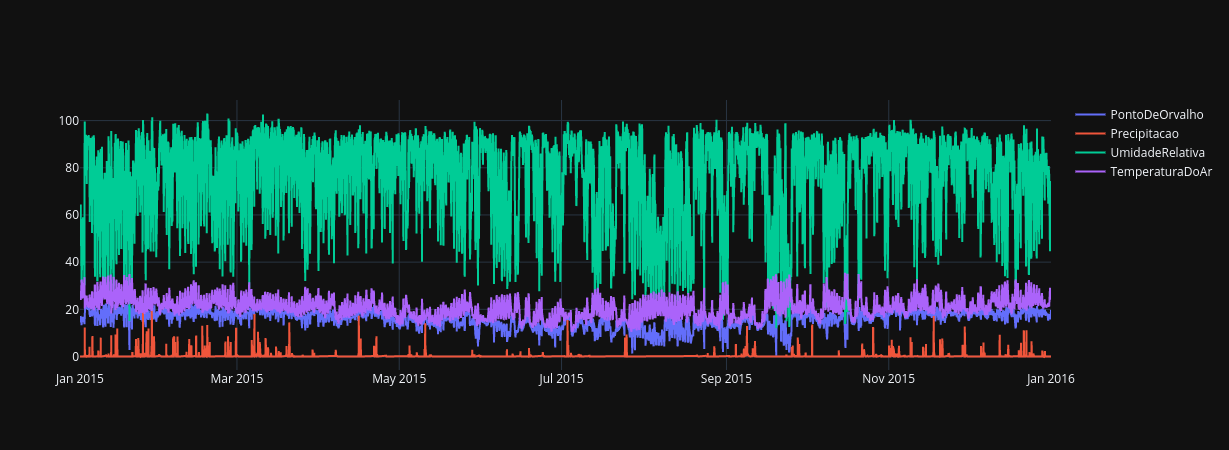

In [5]:
df_plot = original_df[original_df.Data_Hora.dt.year == 2015]

fig = go.Figure(layout=dict(template = 'plotly_dark'))

for col in ['PontoDeOrvalho', 'Precipitacao', 'UmidadeRelativa', 'TemperaturaDoAr']:    
    fig.add_trace(go.Scatter(
        x = df_plot['Data_Hora'],
        y = df_plot[col],
        name = col,
                            )
                 )
fig.show()

# Feature Engineering

In [6]:
interest_cols += ['Diff_Temp_POrvalho']
original_df['Diff_Temp_POrvalho'] = original_df['TemperaturaDoAr'] -  original_df['PontoDeOrvalho']

## Has Rain

In [7]:

has_rain_treshold = 10
precipitacao_sum = original_df.loc[:, ['Date', 'Precipitacao']].groupby('Date').sum()
precipitacao_sum.loc[:, 'Rain_Today'] = precipitacao_sum['Precipitacao'] > has_rain_treshold
precipitacao_sum.loc[:, 'Rain_Next_Day'] = precipitacao_sum.loc[:, 'Rain_Today'].shift(-1)
precipitacao_sum = precipitacao_sum.dropna()

precipitacao_sum.index = pd.to_datetime(precipitacao_sum.index, yearfirst=True)
precipitacao_sum.head()


Precipitacao  Rain_Today Rain_Next_Day
Date                                              
2011-01-01      1.520000       False          True
2011-01-02    139.120000        True          True
2011-01-03     65.875571        True          True
2011-01-04     62.360000        True          True
2011-01-05     11.960000        True          True

# Create Datewise DataFrame 

In [8]:
df = original_df[interest_cols + ['Date' , 'Data_Hora'] ]
df = df.set_index('Data_Hora')

In [9]:
unique_dates = df.index.round('D').unique()
df_date = pd.DataFrame(precipitacao_sum.index, columns = ['Date'])

In [10]:
df_date = df_date.merge(precipitacao_sum.loc[:, ['Rain_Today','Rain_Next_Day']], on = 'Date')
df_date = df_date.set_index('Date')

## Simple Metrics

In [11]:

sum_date = df[interest_cols + ['Date']].groupby('Date').sum()
sum_date.columns = [c + '_sum' for c in sum_date.columns]

median_date = df[interest_cols + ['Date']].groupby('Date').median()
median_date.columns = [c + '_median' for c in median_date.columns]

min_date = df[interest_cols + ['Date']].groupby('Date').min()
min_date.columns = [c + '_min' for c in min_date.columns]

max_date = df[interest_cols + ['Date']].groupby('Date').max()
max_date.columns = [c + '_max' for c in max_date.columns]


In [12]:
df_date = pd.concat([df_date, sum_date, median_date, min_date, max_date], axis = 1)
df_date.head(2)

Rain_Today Rain_Next_Day  Precipitacao_sum  VelocidadeDoVento_sum  \
Date                                                                           
2011-01-01      False          True              1.52             258.009259   
2011-01-02       True          True            139.12             134.788770   

            RadiacaoSolar_sum  TemperaturaDoAr_sum  PontoDeOrvalho_sum  \
Date                                                                     
2011-01-01       14057.252042          1992.746218         1681.052899   
2011-01-02        4910.817248          1878.630158         1798.532057   

            PressaoAtmosferica_sum  UmidadeRelativa_sum  DirecaoDoVento_sum  \
Date                                                                          
2011-01-01            88258.915059          7917.578093        13743.429635   
2011-01-02            88114.280457          9120.762358        19644.838968   

            ...  Diff_Temp_POrvalho_min  Precipitacao_max  \
Date        ...                                             
2011-01-01  ...                0.924580              0.16   
2011-01-02  ...                0.509364              6.96   

            VelocidadeDoVento_max  RadiacaoSolar_max  TemperaturaDoAr_max  \
Date                                                                        
2011-01-01               4.402470         827.451509            24.150000   
2011-01-02               2.773533         355.424594            20.479328   

            PontoDeOrvalho_max  PressaoAtmosferica_max  UmidadeRelativa_max  \
Date                                                                          
2011-01-01           19.149212              921.612206            93.863966   
2011-01-02           19.541844              919.165367            96.573235   

            DirecaoDoVento_max  Diff_Temp_POrvalho_max  
Date                                                    
2011-01-01          188.236373                7.164713  
2011-01-02          325.043926                1.570889  

[2 rows x 38 columns]

## Time Metrics

In [13]:
hours = [3, 9, 15, 21 ]
for selected_hour in hours:

    selected_df = df.loc[(df.index.hour == selected_hour ) & (df.index.minute == 0 ), interest_cols ]
    selected_df.index = selected_df.index.round('D')
    selected_df.columns = [f'{c}_{selected_hour}H' for c in selected_df.columns]
    df_date = pd.concat([df_date, selected_df], axis = 1)

df_date = df_date.dropna(axis = 0)

In [14]:
df_date['Rain_Next_Day'] = df_date['Rain_Next_Day'].astype(int)
df_date['Rain_Today'] = df_date['Rain_Today'].astype(int)

In [15]:
df_date.head()

Rain_Today  Rain_Next_Day  Precipitacao_sum  \
2011-01-02           1              1        139.120000   
2011-01-03           1              1         65.875571   
2011-01-04           1              1         62.360000   
2011-01-05           1              1         11.960000   
2011-01-06           1              1         42.720000   

            VelocidadeDoVento_sum  RadiacaoSolar_sum  TemperaturaDoAr_sum  \
2011-01-02             134.788770        4910.817248          1878.630158   
2011-01-03             157.742309        7056.544026          1950.883170   
2011-01-04             194.357886        9987.621929          2041.322756   
2011-01-05             268.876633       19392.380825          2234.035760   
2011-01-06             258.574365       18553.200000          2202.737789   

            PontoDeOrvalho_sum  PressaoAtmosferica_sum  UmidadeRelativa_sum  \
2011-01-02         1798.532057            88114.280457          9120.762358   
2011-01-03         1822.832572            88108.819209          8869.706039   
2011-01-04         1898.676164            88107.642739          8777.487249   
2011-01-05         1860.973130            88412.377560          7674.131490   
2011-01-06         1836.051325            88551.835972          7756.348267   

            DirecaoDoVento_sum  ...  Diff_Temp_POrvalho_15H  Precipitacao_21H  \
2011-01-02        19644.838968  ...                4.670777              0.00   
2011-01-03        12870.505605  ...                1.040536              0.04   
2011-01-04        10139.030042  ...                2.947215              0.08   
2011-01-05        17820.268917  ...                0.891206              0.00   
2011-01-06        17090.583026  ...                9.574831              0.80   

            VelocidadeDoVento_21H  RadiacaoSolar_21H  TemperaturaDoAr_21H  \
2011-01-02               4.402470                0.0            19.663035   
2011-01-03               0.913005                0.0            19.824446   
2011-01-04               1.120249                0.0            20.073414   
2011-01-05               0.353594                0.0            20.812601   
2011-01-06               2.129717                0.0            22.097521   

            PontoDeOrvalho_21H  PressaoAtmosferica_21H  UmidadeRelativa_21H  \
2011-01-02           18.117964              918.641275            90.325700   
2011-01-03           18.922747              917.859238            94.699543   
2011-01-04           19.426857              917.488114            95.068082   
2011-01-05           19.842249              918.365367            94.145937   
2011-01-06           19.908204              922.265174            87.154319   

            DirecaoDoVento_21H  Diff_Temp_POrvalho_21H  
2011-01-02          171.289637                1.545071  
2011-01-03          325.043926                0.901699  
2011-01-04          142.322584                0.646558  
2011-01-05          222.640389                0.970352  
2011-01-06          232.720686                2.189317  

[5 rows x 74 columns]

## Seasonal Metrics

In [16]:
from datetime import datetime

def get_season(Row):
    
    doy = Row.name.timetuple().tm_yday
    
    fall_start = datetime.strptime('2020-03-20', '%Y-%m-%d' ).timetuple().tm_yday
    summer_start = datetime.strptime('2020-06-20', '%Y-%m-%d' ).timetuple().tm_yday
    spring_start = datetime.strptime('2020-09-22', '%Y-%m-%d' ).timetuple().tm_yday
    spring_end = datetime.strptime('2020-12-21', '%Y-%m-%d' ).timetuple().tm_yday
    
    fall = range(fall_start, summer_start)
    summer = range(summer_start, spring_start)
    spring = range(spring_start, spring_end)
    
    if doy in fall:
        season = 1#'fall'
    elif doy in summer:
        season = 2#'winter'
    elif doy in spring:
        season = 3#'spring'
    else:
        season = 0#'summer' 
    
    return season

df_date['season'] =  df_date.apply(get_season, axis = 1)

In [17]:
df_date.groupby('season').mean()['Precipitacao_sum']

season
0    26.680606
1    10.346377
2     6.079265
3    14.630810
Name: Precipitacao_sum, dtype: float64

# Reference Model

In [18]:
import xgboost as xgb
import catboost as cb
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import sys
sys.path.append('../../Pipeline')

from ml_utils import *

In [19]:
X, y = df_date.drop(columns = ['Rain_Next_Day']), df_date.Rain_Next_Day.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

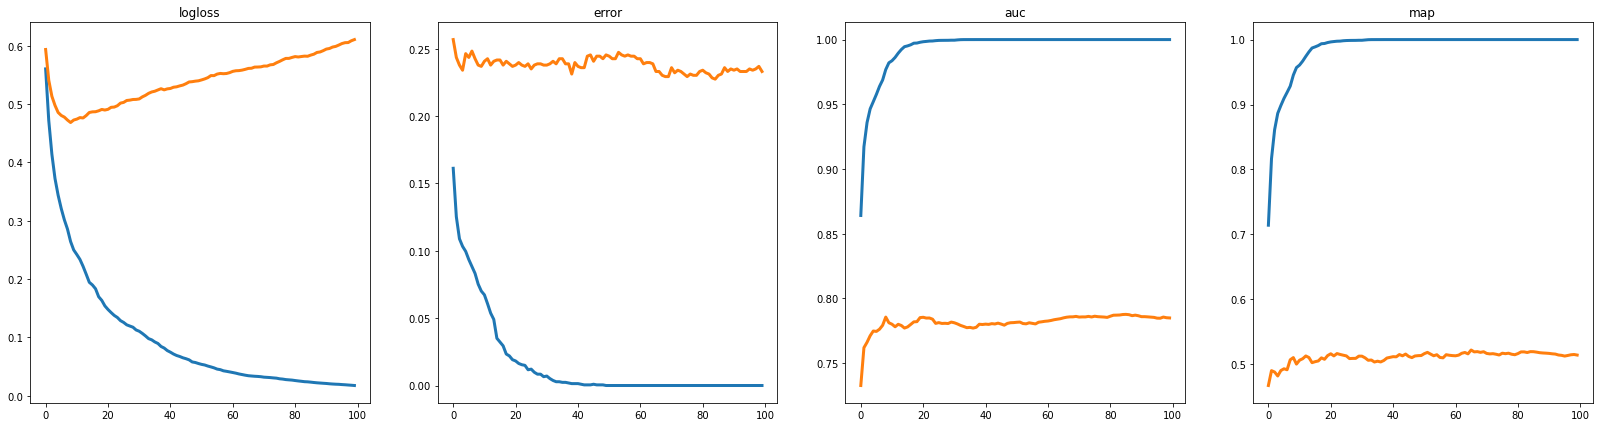

In [20]:
clf = xgb.XGBClassifier(tree_method = 'gpu_hist')

eval_set = [(X_train, y_train), (X_test, y_test)]

clf.fit(X_train, y_train,  eval_metric=["logloss","error", "auc", "map"], eval_set=eval_set, verbose=False);

keys = clf.evals_result()['validation_0'].keys()

fig, ax = plt.subplots( 1, len(keys) ,figsize = (7*len(keys),7))
ax = ax.ravel()
for i, key in enumerate(keys):
    ax[i].set_title(key)
    ax[i].plot(clf.evals_result()['validation_0'][key], lw = 3)
    ax[i].plot(clf.evals_result()['validation_1'][key], lw = 3)
plt.show()

In [21]:
X_test.shape, X_train.shape

((1055, 74), (2139, 74))

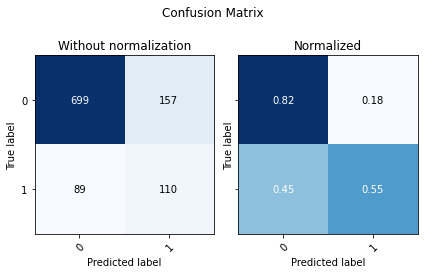

In [22]:
y_pred = clf.predict(X_test)
plot_confusion_matrix(y_pred, y_test, ['0', '1'])

In [23]:
df_date.Rain_Next_Day.value_counts()/df_date.shape[0]

0    0.749217
1    0.250783
Name: Rain_Next_Day, dtype: float64

In [24]:
f1_score(y_pred, y_test)

0.4721030042918455

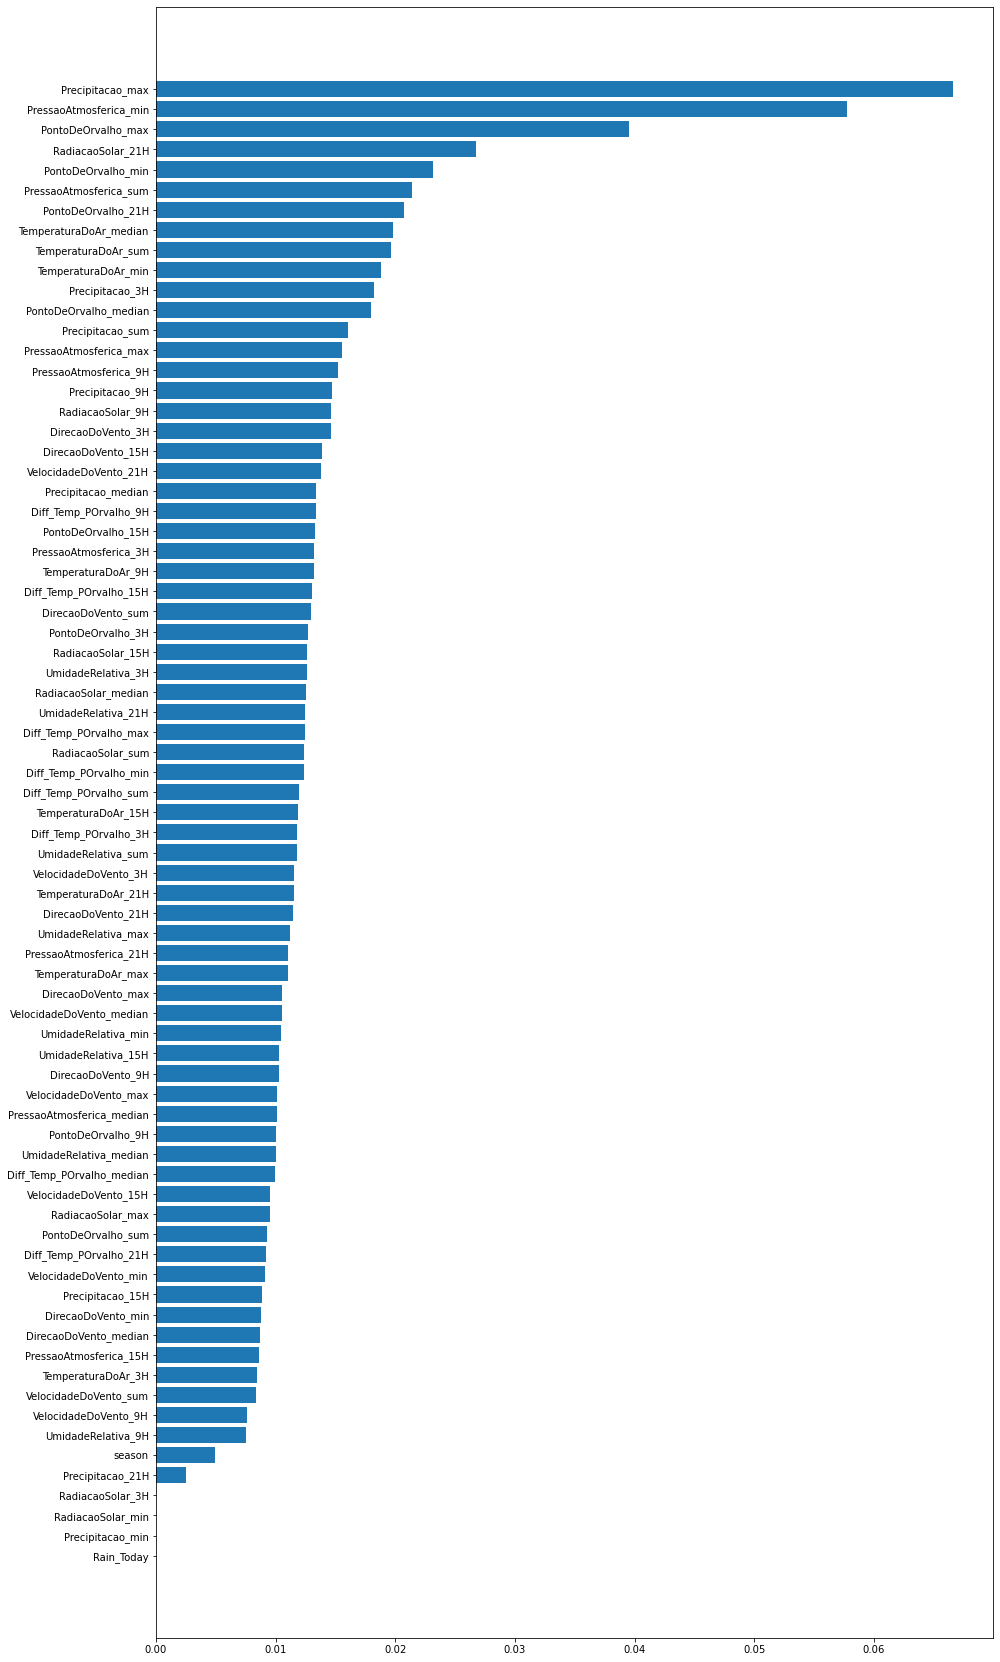

In [25]:
plt.figure(figsize = (15,30))

features_imp = dict(zip(X_train.columns, clf.feature_importances_))
features_imp = {k: v for k, v in sorted(features_imp.items(), key=lambda item: item[1])}

plt.barh(list(features_imp.keys()), features_imp.values())
plt.show()

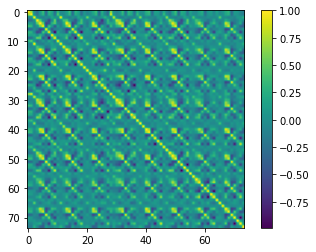

In [26]:
plt.imshow(X_train.corr())
plt.colorbar()
plt.show()

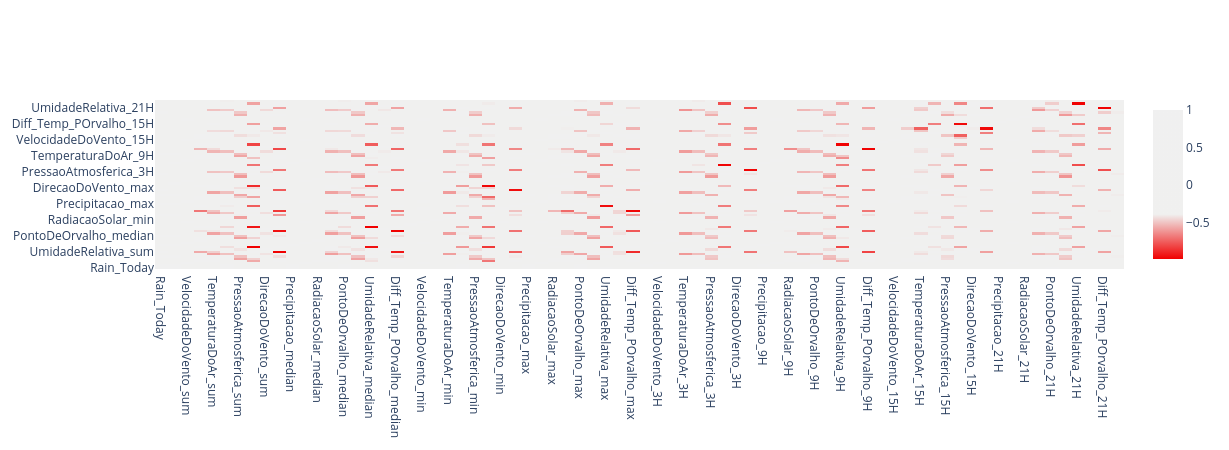

In [27]:
import matplotlib.pyplot as plt

colorscale=[[0.0, "rgb(240, 0, 0)"],
            [0.3, "rgb(240, 240, 239)"],
            [1.0, 'rgb(240, 240, 240)']]

fig = go.Figure()

fig.add_trace(go.Heatmap( z = X_train.corr(),
                         x = X_train.columns,
                         y = X_train.columns, 
                         colorscale = colorscale))
fig.update_layout(width = 200)
fig.show()

In [28]:
X_train['PressaoAtmosferica_sum'].describe()

count     2139.000000
mean     88884.810767
std        332.390100
min      87788.803365
25%      88656.118254
50%      88860.883781
75%      89110.243286
max      90101.250666
Name: PressaoAtmosferica_sum, dtype: float64

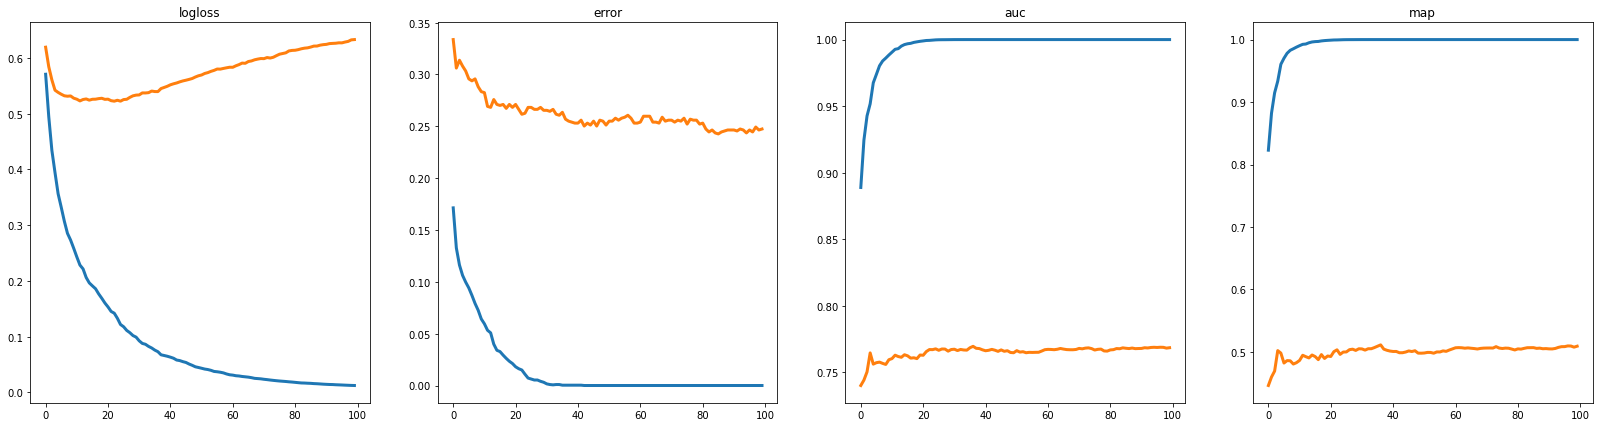

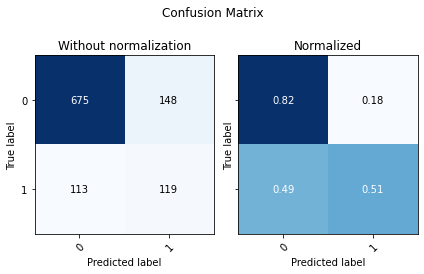

In [29]:
clf = xgb.XGBClassifier(tree_method = 'gpu_hist')

X = pd.concat([X_train.reset_index(drop = True), pd.Series(y_train, name = 'label')], axis = 1)
X_train_up, y_train_up = upsampleData(X, 'label')

eval_set = [(X_train_up, y_train_up), (X_test, y_test)]

clf.fit(X_train_up, y_train_up,  eval_metric=["logloss","error", "auc", "map"],
        eval_set=eval_set, verbose=False);

keys = clf.evals_result()['validation_0'].keys()

fig, ax = plt.subplots( 1, len(keys) ,figsize = (7*len(keys),7))
ax = ax.ravel()
for i, key in enumerate(keys):
    ax[i].set_title(key)
    ax[i].plot(clf.evals_result()['validation_0'][key], lw = 3)
    ax[i].plot(clf.evals_result()['validation_1'][key], lw = 3)
plt.show()

y_pred = clf.predict(X_test)
plot_confusion_matrix(y_pred, y_test, ['0', '1'])